0.865
- MODEL_BB_PATH= '../input/model-bb-1/bond_box_999_200.h5'
- MODEL_PATH = '../input/eff-ns-c/eff4_ns_cropped.h5'
- PATH = "/kaggle/input/plant-pathology-2021-fgvc8/"
- TRAIN_IMG_PATH = PATH+'train_images/'
- TEST_IMG_PATH = PATH+'test_images/'
- BATCH_SIZE = 32
- NUM_CLASSES=6
- SEED = 1488
- IMAGE_SIZE = (380, 380)
- INPUT_SIZE = (380, 380, 3)
- replace ''-'scab'
- model "/app/_data/models/eff4_ns_cropped.h5"
- https://www.kaggle.com/nataliayurasova/plants-effnet4-crop1/edit


In [1]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image

from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

In [2]:
PATH = "/app/_data/"
BATCH_SIZE = 16
SEED = 37
IMAGE_SIZE = 380
NUM_CLASSES = 6
INPUT_SHAPE = (380, 380, 3)
TRAIN_IMG_PATH = "/app/_data/cropped_all_v1/"
TEST_IMG_PATH = "/app/_data/test_images/"

In [3]:
labels = pd.read_csv(PATH + "train_labels.csv")
sample_submission = pd.read_csv(PATH + "sample_submission.csv")
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))
feature_columns = labels.columns[2:].tolist()
feature_columns

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [4]:
labels_2020 = pd.read_csv(PATH + "train_20.csv")
labels_2020["image_id"] = labels_2020["image_id"] + ".jpg"
labels_2020.columns = ["image", "healthy", "complex", "rust", "scab"]
labels_2020 = labels_2020.query("complex !=1").reset_index(drop=True)
labels_2020 = labels_2020[["image", "healthy", "rust", "scab"]]
feature_columns_20 = ["healthy", "rust", "scab"]
for i in labels_2020.index:
    labels_2020.loc[i, "labels_20"] = "".join(
        list(
            map(
                lambda x, y: x * y,
                labels_2020.loc[i, feature_columns_20].values,
                feature_columns_20,
            )
        )
    )

In [5]:
labels_21_20 = pd.concat([labels, labels_2020], axis=0, join="outer", ignore_index=True)
labels_21_20[feature_columns] = labels_21_20[feature_columns].fillna(0).astype("int")
labels_21_20["labels"] = labels_21_20["labels"].fillna(labels_21_20["labels_20"])
labels_21_20 = labels_21_20.drop("labels_20", axis=1)
labels_21_20.head(2)

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,healthy,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,1,1,0,0,0,1


In [7]:
labels_21_20["labels"].value_counts()

scab                               5401
healthy                            5120
frog_eye_leaf_spot                 3175
rust                               2434
complex                            1577
powdery_mildew                     1180
scab frog_eye_leaf_spot             682
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             118
rust complex                         91
powdery_mildew complex               87
Name: labels, dtype: int64

### StratifiedShuffleSplit

 - v1 - labels_long_1 0.812+scab
 - v2 - labels_21_20 - 0,78 + scab
 - v3 - labels+all_wrong*4 0.574 +scab
 - v3 - labels + upsampling

In [8]:
df = labels_21_20.copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.07, random_state=SEED)

for train_index, valid_index in sss.split(df["image"], df["labels"]):
    train, valid = df.loc[train_index], df.loc[valid_index]

In [9]:
def pred_to_labels(pred, thresh=0.5, labels=feature_columns):
    pred = [labels[i] for i in range(len(labels)) if pred[i] > thresh]
    pred = " ".join(pred)
    return pred

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal_and_vertical", seed=SEED
        ),
        keras.layers.experimental.preprocessing.RandomRotation(0.5, seed=SEED),
        keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1, seed=SEED),
        keras.layers.experimental.preprocessing.RandomContrast(factor=0.3, seed=SEED),
        keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.1, width_factor=0.1, seed=SEED
        ),
    ]
)

In [12]:
# from 380 uint8
def parse_image(file_path):
    img = tf.io.read_file(PATH + "cropped_all_v1/" + file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [13]:
def prepare_dataset(df, augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["image"].values, df[feature_columns].astype("uint8").values)
    )
    dataset = dataset.map(lambda x, y: (parse_image(x), y))
    dataset = dataset.batch(BATCH_SIZE)

    if augmentation:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )
    dataset = dataset.repeat().prefetch(buffer_size=AUTOTUNE)
    return dataset

In [14]:
ds_train = prepare_dataset(train, augmentation=True)
ds_valid = prepare_dataset(valid)

In [15]:
for a, b in ds_train.take(1):
    print(a[0].dtype, b.dtype)
    print(a[0].shape, b.shape)

<dtype: 'uint8'> <dtype: 'uint8'>
(380, 380, 3) (16, 6)


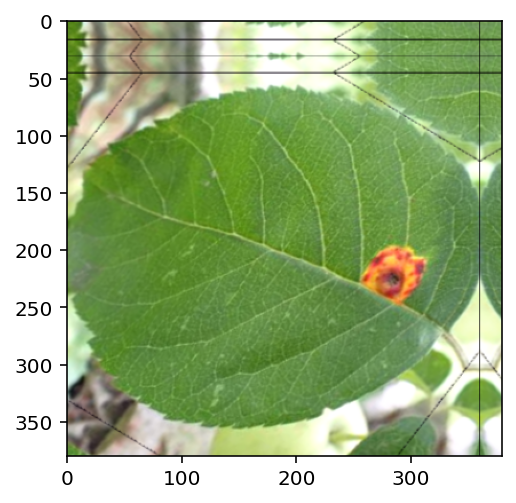

In [16]:
plt.imshow(a[0])

In [17]:
def parse_test_image(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(
        img,
        IMAGE_SIZE,
    )
    img = tf.image.convert_image_dtype(img, tf.uint8)
    return img
def predict_new(path, model):
    img = parse_test_image(path)
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

In [18]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 5000, compute capability 7.5


In [24]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_score",
        patience=10,
        restore_best_weights=True,
        verbose=0,
        mode="max",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/eff4_imagenet_cropped.h5",
        monitor="val_f1_score",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1_score",
        factor=0.2,
        patience=3,
        verbose=0,
        mode="max",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
]

In [25]:
# base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
# base_model.load_weights('/app/_data/models/efficientnet-b4_noisy-student_notop.h5', by_name=True, skip_mismatch = True)

In [26]:
inputs = keras.Input(shape=INPUT_SHAPE)
base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
base_model.load_weights(
    "/app/_data/models/efficientnet-b4_noisy-student_notop.h5",
    by_name=True,
    skip_mismatch=True,
)
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=[
        "acc",
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="weighted"),
    ],
)

In [1]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    steps_per_epoch=(train.shape[0] * 0.9) // BATCH_SIZE,
    validation_steps=(valid.shape[0] * 0.1) // BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks=callbacks,
)

In [ ]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

In [ ]:
plot_curves(history, loss=True)

In [30]:
def parse_all(file_path):
    img = tf.io.read_file(TRAIN_IMG_PATH+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img
def predict_new(path, model):
    img = parse_all(path)
    img = tf.expand_dims(img,axis = 0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

In [31]:
df_sub = pd.DataFrame(columns=['image','labels'])
for img_name in os.listdir(TRAIN_IMG_PATH):
    pred = predict_new(img_name, model)

    df_sub = df_sub.append( {'image': img_name, 'labels': pred}, ignore_index = True )

print(df_sub.head())

                  image                   labels
0  bfc6d90f402f4c34.jpg  frog_eye_leaf_spot scab
1  9eb93fe282326266.jpg           powdery_mildew
2  f4cb3a8f41b413e4.jpg       frog_eye_leaf_spot
3  98322eab16bef2c1.jpg                     rust
4  dad5d6250cae80b7.jpg                  complex


In [32]:
df_sub = df_sub.merge(
    labels_21_20[["image", "labels"]],
    on="image",
    how="left",
    suffixes=("_pred", "_true"),
)

In [33]:
df_sub.to_csv("/app/sandbox/wrong_predictions/eff4/eff4_ns_cropped_2.csv")

In [35]:
df_sub[df_sub["labels_pred"] == ""]["labels_true"].value_counts()

complex                    22
scab                       10
rust                        7
frog_eye_leaf_spot          5
scab frog_eye_leaf_spot     1
rust frog_eye_leaf_spot     1
powdery_mildew complex      1
powdery_mildew              1
healthy                     1
Name: labels_true, dtype: int64

In [37]:
df_sub[df_sub["labels_pred"] != df_sub["labels_true"]]["labels_true"].value_counts()

scab frog_eye_leaf_spot            682
complex                            438
scab frog_eye_leaf_spot complex    200
frog_eye_leaf_spot complex         165
scab                               124
rust frog_eye_leaf_spot            118
rust complex                        91
powdery_mildew complex              87
rust                                74
frog_eye_leaf_spot                  71
healthy                             19
powdery_mildew                       7
Name: labels_true, dtype: int64